In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchtext.legacy.datasets import Multi30k
from torchtext.legacy.data import Field, BucketIterator
import spacy
import numpy as np
import random
from tqdm import tqdm
from torchtext.data.metrics import bleu_score
import matplotlib.pyplot as plt

/home/joeltech/micromamba/nn_p2/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
def get_datasets(batch_size=128):
    spacy_de = spacy.load('de_core_news_sm')
    spacy_en = spacy.load('en_core_web_sm')

    def tokenize_de(text):
        return [token.text for token in spacy_de.tokenizer(text)][::-1]

    def tokenize_en(text):
        return [token.text for token in spacy_en.tokenizer(text)]

    source = Field(tokenize=tokenize_de, init_token='<sos>', eos_token='<eos>', lower=True)
    target = Field(tokenize=tokenize_en, init_token='<sos>', eos_token='<eos>', lower=True)

    train_data, valid_data, test_data = Multi30k.splits(exts=('.de', '.en'), fields=(source, target))

    # Build the vocabulary for both the language
    source.build_vocab(train_data, min_freq=3)
    target.build_vocab(train_data, min_freq=3)

    train_iterator, valid_iterator, test_iterator = BucketIterator.splits((train_data, valid_data, test_data),
                                                                          batch_size=batch_size,
                                                                          sort_within_batch=True,
                                                                          sort_key=lambda x: len(x.src),
                                                                          device=device)
    return train_iterator, valid_iterator, test_iterator, source, target

In [4]:
def get_test_datasets():
    spacy_de = spacy.load('de_core_news_sm')
    spacy_en = spacy.load('en_core_web_sm')

    def tokenize_de(text):
        return [token.text for token in spacy_de.tokenizer(text)][::-1]

    def tokenize_en(text):
        return [token.text for token in spacy_en.tokenizer(text)]

    source = Field(tokenize=tokenize_de, init_token='<sos>', eos_token='<eos>', lower=True)
    target = Field(tokenize=tokenize_en, init_token='<sos>', eos_token='<eos>', lower=True)

    _, _, test_data = Multi30k.splits(exts=('.de', '.en'), fields=(source, target))

    return test_data

## <b>Exploring the Dataset</b>

In [8]:
def tokenize_de(text):
        return [token.text for token in spacy_de.tokenizer(text)][::-1]

def tokenize_en(text):
    return [token.text for token in spacy_en.tokenizer(text)]

spacy_de = spacy.load('de_core_news_sm')
spacy_en = spacy.load('en_core_web_sm')

source = Field(tokenize=tokenize_de, init_token='<sos>', eos_token='<eos>', lower=True)
target = Field(tokenize=tokenize_en, init_token='<sos>', eos_token='<eos>', lower=True)

train_data, valid_data, test_data = Multi30k.splits(exts=('.de', '.en'), fields=(source, target))

In [9]:
len(train_data)

29000

In [10]:
len(valid_data)

1014

In [11]:
len(test_data)

1000

In [12]:
src = vars(test_data.examples[0])['src']
trg = vars(test_data.examples[0])['trg']
print(' '.join(src))
print(' '.join(trg))

. anstarrt etwas der , hut orangefarbenen einem mit mann ein
a man in an orange hat starring at something .


In [13]:
src = vars(test_data.examples[2])['src']
trg = vars(test_data.examples[2])['trg']
print(' '.join(src))
print(' '.join(trg))

. tritt einem mit brett ein bricht karateanzug einem in mädchen ein
a girl in karate uniform breaking a stick with a front kick .


In [19]:
src = vars(test_data.examples[3])['src']
trg = vars(test_data.examples[3])['trg']
print(' '.join(src))
print(' '.join(trg))

. hintergrund im schneemobilen mit schnee im stehen helmen mit und winterjacken in leute fünf
five people wearing winter jackets and helmets stand in the snow , with snowmobiles in the background .


In [20]:
lengths = []
for i in range(len(train_data)):
    src = vars(train_data.examples[i])['src']
    target = vars(train_data.examples[i])['trg']
    if len(src) != 1:
        lengths.append(len(src))

for i in range(len(valid_data)):
    src = vars(valid_data.examples[i])['src']
    target = vars(valid_data.examples[i])['trg']
    if len(src) != 1:
        lengths.append(len(src))

for i in range(len(test_data)):
    src = vars(test_data.examples[i])['src']
    target = vars(test_data.examples[i])['trg']
    if len(src) != 1:
        lengths.append(len(src))

In [21]:
print(min(lengths))
print(max(lengths))

2
44


In [22]:
count10=0
count15=0
countrest=0

for length in lengths:
    if length <=10:
        count10+=1
    elif length >10 and length <=15:
        count15+=1
    elif length > 15:
        countrest+=1

In [23]:
print(count10)
print(count15)
print(countrest)

11359
13393
6260


## <b> Experiment 1 - Implementing a basic LSTM model and evaluate how it performs at different sequence length </b>

In [24]:
class Encoder(nn.Module):
    def __init__(self, vocab_len, embedding_dim, hidden_dim, n_layers, dropout_prob):
        super().__init__()

        self.embedding = nn.Embedding(vocab_len, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers, dropout=dropout_prob)

        self.dropout = nn.Dropout(dropout_prob)

    def forward(self, input_batch):
        embed = self.dropout(self.embedding(input_batch))
        outputs, (hidden, cell) = self.lstm(embed)

        return hidden, cell

In [25]:
class OneStepDecoder(nn.Module):
    def __init__(self, input_output_dim, embedding_dim, hidden_dim, n_layers, dropout_prob):
        super().__init__()
        self.input_output_dim = input_output_dim

        self.embedding = nn.Embedding(input_output_dim, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers, dropout=dropout_prob)
        self.fc = nn.Linear(hidden_dim, input_output_dim)
        self.dropout = nn.Dropout(dropout_prob)

    def forward(self, target_token, hidden, cell):
        target_token = target_token.unsqueeze(0)
        embedding_layer = self.dropout(self.embedding(target_token))
        output, (hidden, cell) = self.lstm(embedding_layer, (hidden, cell))

        linear = self.fc(output.squeeze(0))

        return linear, hidden, cell


class Decoder(nn.Module):
    def __init__(self, one_step_decoder, device):
        super().__init__()
        self.one_step_decoder = one_step_decoder
        self.device = device

    def forward(self, target, hidden, cell):
        target_len, batch_size = target.shape[0], target.shape[1]
        target_vocab_size = self.one_step_decoder.input_output_dim

        predictions = torch.zeros(target_len, batch_size, target_vocab_size).to(self.device)
        # Take the very first word token, which will be sos
        input = target[0, :]

        # Loop through all the time steps, starts from 1
        for t in range(1, target_len):
            predict, hidden, cell = self.one_step_decoder(input, hidden, cell)

            predictions[t] = predict
            input = predict.argmax(1)

        return predictions

In [26]:
class EncoderDecoder(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()

        self.encoder = encoder
        self.decoder = decoder

    def forward(self, source, target):
        hidden, cell = self.encoder(source)
        outputs = self.decoder(target, hidden, cell)

        return outputs

In [27]:
def create_model(source, target, embedding_dim, hidden_dim, dropout):
    # Instanciate the models
    encoder = Encoder(len(source.vocab), embedding_dim, hidden_dim, n_layers=2, dropout_prob=dropout)
    one_step_decoder = OneStepDecoder(len(target.vocab), embedding_dim, hidden_dim, n_layers=2, dropout_prob=dropout)
    decoder = Decoder(one_step_decoder, device)

    model = EncoderDecoder(encoder, decoder)

    model = model.to(device)

    optimizer = optim.Adam(model.parameters())

    # Makes sure the CrossEntropyLoss ignores the padding tokens.
    TARGET_PAD_IDX = target.vocab.stoi[target.pad_token]
    criterion = nn.CrossEntropyLoss(ignore_index=TARGET_PAD_IDX)

    return model, optimizer, criterion

In [28]:
def train(model, optimizer, criterion, train_iterator, valid_iterator, epochs=25):
    training_loss_epoch = []
    validation_loss_epoch = []
    for epoch in range(1, epochs + 1):
        pbar = tqdm(total=len(train_iterator), bar_format='{l_bar}{bar:10}{r_bar}{bar:-10b}', unit=' batches', ncols=200)

        training_loss = []
        model.train()

        for i, batch in enumerate(train_iterator):
            src = batch.src
            trg = batch.trg

            optimizer.zero_grad()
            output = model(src, trg)

            output_dim = output.shape[-1]

            # Discard the first token as this will always be 0
            output = output[1:].view(-1, output_dim)

            # Discard the sos token from target
            trg = trg[1:].view(-1)

            loss = criterion(output, trg)
            loss.backward()
            optimizer.step()

            training_loss.append(loss.item())

            pbar.set_postfix(
                epoch=f" {epoch}, train loss= {round(sum(training_loss) / len(training_loss), 4)}", refresh=True)
            pbar.update()

        with torch.no_grad():
            # Set the model to eval
            model.eval()

            validation_loss = []

            # Loop through the validation batch
            for i, batch in enumerate(valid_iterator):
                src = batch.src
                trg = batch.trg

                output = model(src, trg)

                output_dim = output.shape[-1]
                output = output[1:].view(-1, output_dim)
                trg = trg[1:].view(-1)

                loss = criterion(output, trg)

                validation_loss.append(loss.item())

        pbar.set_postfix(
            epoch=f" {epoch}, train loss= {round(sum(training_loss) / len(training_loss), 4)}, val loss= {round(sum(validation_loss) / len(validation_loss), 4)}",
            refresh=False)
        pbar.close()
        
        training_loss_epoch.append(round(sum(training_loss) / len(training_loss), 4))
        validation_loss_epoch.append(round(sum(validation_loss) / len(validation_loss), 4))

    plt.title("Traning Loss")
    plt.xticks(range(len(training_loss_epoch)))
    plt.plot(training_loss_epoch, color="blue")
    plt.show()
    
    plt.title("Validation Loss")
    plt.xticks(range(len(validation_loss_epoch)))
    plt.plot(validation_loss_epoch, color="green")
    plt.show()
    
    return model

In [29]:
def predict(id, model, source_vocab, target_vocab, test_data):
    src = vars(test_data.examples[id])['src']
    trg = vars(test_data.examples[id])['trg']

    # Convert each source token to integer values using the vocabulary
    tokens = ['<sos>'] + [token.lower() for token in src] + ['<eos>']
    src_indexes = [source_vocab.stoi[token] for token in tokens]
    src_tensor = torch.LongTensor(src_indexes).unsqueeze(1).to(device)

    model.eval()

    # Run the forward pass of the encoder
    hidden, cell = model.encoder(src_tensor)

    # Take the integer value of <sos> from the target vocabulary.
    trg_index = [target_vocab.stoi['<sos>']]
    next_token = torch.LongTensor(trg_index).to(device)

    outputs = []
    trg_indexes = []

    with torch.no_grad():
        # Use the hidden and cell vector of the Encoder and in loop
        # run the forward pass of the OneStepDecoder until some specified
        # step (say 50) or when <eos> has been generated by the model.
        for _ in range(30):
            output, hidden, cell = model.decoder.one_step_decoder(next_token, hidden, cell)

            # Take the word with highest probablilty
            next_token = output.argmax(1)

            trg_indexes.append(next_token.item())

            # change token back to the respective word
            predicted = target_vocab.itos[output.argmax(1).item()]
            if predicted == '<eos>':
                break
            else:
                outputs.append(predicted)  

    predicted_words = [target_vocab.itos[i] for i in trg_indexes]
    return src, trg, predicted_words

In [30]:
def evaluate(dataset, model, source_vocab, target_vocab):
    targets = []
    predictions = []

    for i in range(len(dataset)):
        target = vars(test_data.examples[i])['trg']
        _, _, predicted_words = predict(i, model, source_vocab, target_vocab, dataset)
        predictions.append(predicted_words[1:-1])
        targets.append([target])

    print(f'BLEU Score: {round(bleu_score(predictions, targets) * 100, 2)}')

100%|██████████| 57/57 [00:30<00:00,  1.89 batches/s, epoch=30, train loss= 1.8303, val loss= 3.4912]                                                                                                   


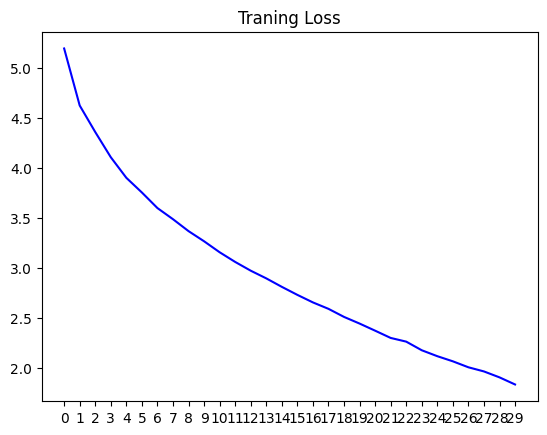

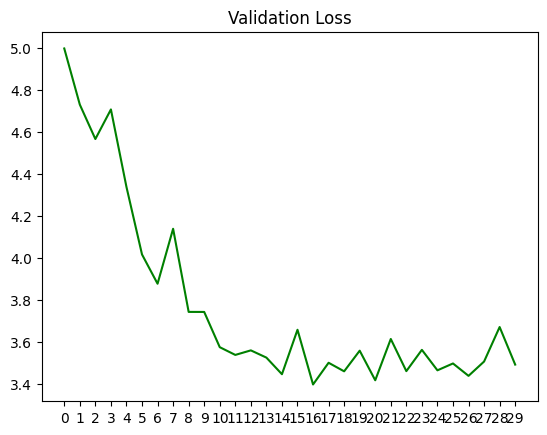

In [31]:
embedding_dim = 256
hidden_dim = 1024
dropout = 0.5

train_iterator, valid_iterator, test_iterator, source, target = get_datasets(batch_size=512)
model, optimizer, criterion = create_model(source, target, embedding_dim, hidden_dim, dropout)

model = train(model, optimizer, criterion, train_iterator, valid_iterator, epochs=30)

In [32]:
test_data = get_test_datasets()

In [33]:
input, truth, predicted = predict(20, model, source.vocab, target.vocab, test_data)
print(f'Input sentence         = {" ".join(input)}')
print(f'Predicted sentence     = {" ".join(predicted)}')
print(f'Ground Truth sentence  = {" ".join(truth)}')

Input sentence         = . stehen gebäude einem vor die , leute
Predicted sentence     = people standing in front of a building . <eos>
Ground Truth sentence  = people standing outside of a building .


In [34]:
input, truth, predicted = predict(40, model, source.vocab, target.vocab, test_data)
print(f'Input sentence         = {" ".join(input)}')
print(f'Predicted sentence     = {" ".join(predicted)}')
print(f'Ground Truth sentence  = {" ".join(truth)}')

Input sentence         = . wasser im treibt rettungsweste einer in mädchen ein
Predicted sentence     = a girl in a life jacket is splashing in water . <eos>
Ground Truth sentence  = a girl wearing a life vest floats in water .


In [36]:
input, truth, predicted = predict(10, model, source.vocab, target.vocab, test_data)
print(f'Input sentence         = {" ".join(input)}')
print(f'Predicted sentence     = {" ".join(predicted)}')
print(f'Ground Truth sentence  = {" ".join(truth)}')

Input sentence         = . freien im tag schönen einen genießen sohn kleiner ihr und mutter eine
Predicted sentence     = a mother and her son enjoying enjoying a day day outdoors outdoors . <eos>
Ground Truth sentence  = a mother and her young song enjoying a beautiful day outside .


### <b> Sequences of Any length (All sentences) </b>

In [15]:
evaluate(test_data, model, source.vocab, target.vocab)

BLEU Score: 14.83


### <b> Sequence length <= 10 Words </b>

In [16]:
def evaluate(dataset, model, source_vocab, target_vocab):
    targets = []
    predictions = []

    for i in range(len(dataset)):
        src = vars(test_data.examples[i])['src']
        target = vars(test_data.examples[i])['trg']
        if len(src) <= 10:
            _, _, predicted_words = predict(i, model, source_vocab, target_vocab, dataset)
            predictions.append(predicted_words[1:-1])
            targets.append([target])

    print(f'BLEU Score: {round(bleu_score(predictions, targets) * 100, 2)}')
    return predictions

In [17]:
test_data = get_test_datasets()

In [18]:
predictions = evaluate(test_data, model, source.vocab, target.vocab)

BLEU Score: 18.14


In [19]:
len(predictions)

397

### <b> Sequence length > 10 Words and <=15 Words </b>

In [20]:
def evaluate(dataset, model, source_vocab, target_vocab):
    targets = []
    predictions = []

    for i in range(len(dataset)):
        src = vars(test_data.examples[i])['src']
        target = vars(test_data.examples[i])['trg']
        if len(src) > 10 and len(src) <= 15:
            _, _, predicted_words = predict(i, model, source_vocab, target_vocab, dataset)
            predictions.append(predicted_words[1:-1])
            targets.append([target])

    print(f'BLEU Score: {round(bleu_score(predictions, targets) * 100, 2)}')
    return predictions

In [21]:
test_data = get_test_datasets()

In [22]:
predictions = evaluate(test_data, model, source.vocab, target.vocab)

BLEU Score: 14.12


In [23]:
len(predictions)

432

### <b> Sequence length > 15 Words</b>

In [24]:
def evaluate(dataset, model, source_vocab, target_vocab):
    targets = []
    predictions = []

    for i in range(len(dataset)):
        src = vars(test_data.examples[i])['src']
        target = vars(test_data.examples[i])['trg']
        if len(src) > 15:
            _, _, predicted_words = predict(i, model, source_vocab, target_vocab, dataset)
            predictions.append(predicted_words[1:-1])
            targets.append([target])

    print(f'BLEU Score: {round(bleu_score(predictions, targets) * 100, 2)}')
    return predictions

In [25]:
test_data = get_test_datasets()

In [26]:
predictions = evaluate(test_data, model, source.vocab, target.vocab)

BLEU Score: 12.38


In [27]:
len(predictions)

171

## <b> Experiment 2 - Exploring the idea of Teacher Forcing </b>

### <b> With Teacher Forcing </b>

In [37]:
class Encoder(nn.Module):
    def __init__(self, vocab_len, embedding_dim, hidden_dim, n_layers, dropout_prob):
        super().__init__()

        self.embedding = nn.Embedding(vocab_len, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers, dropout=dropout_prob)

        self.dropout = nn.Dropout(dropout_prob)

    def forward(self, input_batch):
        embed = self.dropout(self.embedding(input_batch))
        outputs, (hidden, cell) = self.lstm(embed)

        return hidden, cell

In [38]:
class OneStepDecoder(nn.Module):
    def __init__(self, input_output_dim, embedding_dim, hidden_dim, n_layers, dropout_prob):
        super().__init__()
        self.input_output_dim = input_output_dim

        self.embedding = nn.Embedding(input_output_dim, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers, dropout=dropout_prob)
        self.fc = nn.Linear(hidden_dim, input_output_dim)
        self.dropout = nn.Dropout(dropout_prob)

    def forward(self, target_token, hidden, cell):
        target_token = target_token.unsqueeze(0)
        embedding_layer = self.dropout(self.embedding(target_token))
        output, (hidden, cell) = self.lstm(embedding_layer, (hidden, cell))

        linear = self.fc(output.squeeze(0))

        return linear, hidden, cell


class Decoder(nn.Module):
    def __init__(self, one_step_decoder, device):
        super().__init__()
        self.one_step_decoder = one_step_decoder
        self.device = device

    def forward(self, target, hidden, cell, teacher_forcing_ratio=0.5):
        target_len, batch_size = target.shape[0], target.shape[1]
        target_vocab_size = self.one_step_decoder.input_output_dim

        predictions = torch.zeros(target_len, batch_size, target_vocab_size).to(self.device)
        input = target[0, :]

        # Loop through all the time steps, starts from 1
        for t in range(1, target_len):
            predict, hidden, cell = self.one_step_decoder(input, hidden, cell)

            predictions[t] = predict
            input = predict.argmax(1)

            # Teacher forcing--------------------------------------------------------------------------------------------------------------------------
            do_teacher_forcing = random.random() < teacher_forcing_ratio
            input = target[t] if do_teacher_forcing else input

        return predictions

In [39]:
class EncoderDecoder(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()

        self.encoder = encoder
        self.decoder = decoder

    def forward(self, source, target, teacher_forcing_ratio=0.5):
        hidden, cell = self.encoder(source)
        outputs = self.decoder(target, hidden, cell, teacher_forcing_ratio)

        return outputs

In [40]:
def create_model(source, target, embedding_dim, hidden_dim, dropout):
    encoder = Encoder(len(source.vocab), embedding_dim, hidden_dim, n_layers=2, dropout_prob=dropout)
    one_step_decoder = OneStepDecoder(len(target.vocab), embedding_dim, hidden_dim, n_layers=2, dropout_prob=dropout)
    decoder = Decoder(one_step_decoder, device)

    model = EncoderDecoder(encoder, decoder)

    model = model.to(device)
    optimizer = optim.Adam(model.parameters())

    TARGET_PAD_IDX = target.vocab.stoi[target.pad_token]
    criterion = nn.CrossEntropyLoss(ignore_index=TARGET_PAD_IDX)

    return model, optimizer, criterion

In [41]:
def train(model, optimizer, criterion, train_iterator, valid_iterator, epochs=25):
    training_loss_epoch = []
    validation_loss_epoch = []
    for epoch in range(1, epochs + 1):
        pbar = tqdm(total=len(train_iterator), bar_format='{l_bar}{bar:10}{r_bar}{bar:-10b}', unit=' batches', ncols=200)

        training_loss = []
        model.train()

        for i, batch in enumerate(train_iterator):
            src = batch.src
            trg = batch.trg

            optimizer.zero_grad()

            output = model(src, trg)
            output_dim = output.shape[-1]

            # Discard the first token as this will always be 0
            output = output[1:].view(-1, output_dim)

            # Discard the sos token from target
            trg = trg[1:].view(-1)

            loss = criterion(output, trg)
            loss.backward()
            optimizer.step()

            training_loss.append(loss.item())

            pbar.set_postfix(
                epoch=f" {epoch}, train loss= {round(sum(training_loss) / len(training_loss), 4)}", refresh=True)
            pbar.update()

        with torch.no_grad():
            model.eval()

            validation_loss = []

            # Loop through the validation batch
            for i, batch in enumerate(valid_iterator):
                src = batch.src
                trg = batch.trg

                output = model(src, trg, 0)
                output_dim = output.shape[-1]
                output = output[1:].view(-1, output_dim)
                trg = trg[1:].view(-1)

                loss = criterion(output, trg)

                validation_loss.append(loss.item())

        pbar.set_postfix(
            epoch=f" {epoch}, train loss= {round(sum(training_loss) / len(training_loss), 4)}, val loss= {round(sum(validation_loss) / len(validation_loss), 4)}",
            refresh=False)
        pbar.close()
        
        training_loss_epoch.append(round(sum(training_loss) / len(training_loss), 4))
        validation_loss_epoch.append(round(sum(validation_loss) / len(validation_loss), 4))

    plt.title("Traning Loss")
    plt.xticks(range(len(training_loss_epoch)))
    plt.plot(training_loss_epoch, color="blue")
    plt.show()
    
    plt.title("Validation Loss")
    plt.xticks(range(len(validation_loss_epoch)))
    plt.plot(validation_loss_epoch, color="green")
    plt.show()

    return model

In [42]:
def predict(id, model, source_vocab, target_vocab, test_data):
    src = vars(test_data.examples[id])['src']
    trg = vars(test_data.examples[id])['trg']

    # Convert each source token to integer values using the vocabulary
    tokens = ['<sos>'] + [token.lower() for token in src] + ['<eos>']
    src_indexes = [source_vocab.stoi[token] for token in tokens]
    src_tensor = torch.LongTensor(src_indexes).unsqueeze(1).to(device)

    model.eval()
    hidden, cell = model.encoder(src_tensor)

    # Take the integer value of <sos> from the target vocabulary.
    trg_index = [target_vocab.stoi['<sos>']]
    next_token = torch.LongTensor(trg_index).to(device)

    outputs = []
    trg_indexes = []

    with torch.no_grad():
        # Use the hidden and cell vector of the Encoder and in loop
        # run the forward pass of the OneStepDecoder until some specified
        # step (say 50) or when <eos> has been generated by the model.
        for _ in range(30):
            output, hidden, cell = model.decoder.one_step_decoder(next_token, hidden, cell)
            next_token = output.argmax(1)
            trg_indexes.append(next_token.item())

            # change token back to the respective word
            predicted = target_vocab.itos[output.argmax(1).item()]
            if predicted == '<eos>':
                break
            else:
                outputs.append(predicted)  

    predicted_words = [target_vocab.itos[i] for i in trg_indexes]
    return src, trg, predicted_words

In [43]:
def evaluate(dataset, model, source_vocab, target_vocab):
    targets = []
    predictions = []

    for i in range(len(dataset)):
        target = vars(test_data.examples[i])['trg']
        _, _, predicted_words = predict(i, model, source_vocab, target_vocab, dataset)
        predictions.append(predicted_words[1:-1])
        targets.append([target])

    print(f'BLEU Score: {round(bleu_score(predictions, targets) * 100, 2)}')

100%|██████████| 57/57 [00:30<00:00,  1.89 batches/s, epoch=30, train loss= 1.5401, val loss= 3.8089]                                                                                                   


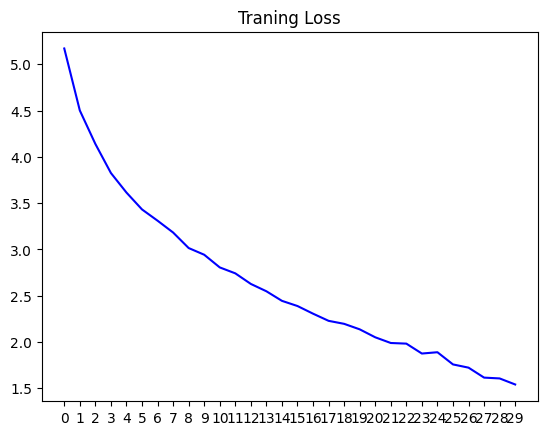

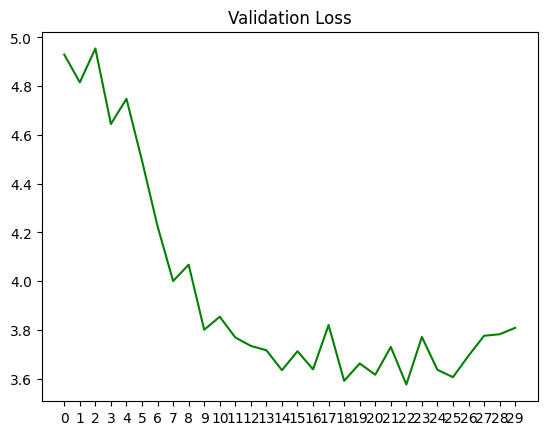

In [44]:
embedding_dim = 256
hidden_dim = 1024
dropout = 0.5

train_iterator, valid_iterator, test_iterator, source, target = get_datasets(batch_size=512)
model, optimizer, criterion = create_model(source, target, embedding_dim, hidden_dim, dropout)

model = train(model, optimizer, criterion, train_iterator, valid_iterator, epochs=30)

In [45]:
test_data = get_test_datasets()

In [46]:
input, truth, predicted = predict(20, model, source.vocab, target.vocab, test_data)
print(f'Input sentence         = {" ".join(input)}')
print(f'Predicted sentence     = {" ".join(predicted)}')
print(f'Ground Truth sentence  = {" ".join(truth)}')

Input sentence         = . stehen gebäude einem vor die , leute
Predicted sentence     = people standing in front of a building . <eos>
Ground Truth sentence  = people standing outside of a building .


In [47]:
input, truth, predicted = predict(40, model, source.vocab, target.vocab, test_data)
print(f'Input sentence         = {" ".join(input)}')
print(f'Predicted sentence     = {" ".join(predicted)}')
print(f'Ground Truth sentence  = {" ".join(truth)}')

Input sentence         = . wasser im treibt rettungsweste einer in mädchen ein
Predicted sentence     = a girl in a bathing bathing jacket is in the water . <eos>
Ground Truth sentence  = a girl wearing a life vest floats in water .


In [48]:
input, truth, predicted = predict(10, model, source.vocab, target.vocab, test_data)
print(f'Input sentence         = {" ".join(input)}')
print(f'Predicted sentence     = {" ".join(predicted)}')
print(f'Ground Truth sentence  = {" ".join(truth)}')

Input sentence         = . freien im tag schönen einen genießen sohn kleiner ihr und mutter eine
Predicted sentence     = a mother and her son enjoying a day outdoors . <eos>
Ground Truth sentence  = a mother and her young song enjoying a beautiful day outside .


In [38]:
evaluate(test_data, model, source.vocab, target.vocab)

BLEU Score: 20.42


## <b> Experiment 3 - Exploring the idea of Gradient Clipping </b>

### <b> Without Gradient Clipping - Same as above - But added a graph to track the gradients </b>

In [27]:
class Encoder(nn.Module):
    def __init__(self, vocab_len, embedding_dim, hidden_dim, n_layers, dropout_prob):
        super().__init__()

        self.embedding = nn.Embedding(vocab_len, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers, dropout=dropout_prob)

        self.dropout = nn.Dropout(dropout_prob)

    def forward(self, input_batch):
        embed = self.dropout(self.embedding(input_batch))
        outputs, (hidden, cell) = self.lstm(embed)

        return hidden, cell

In [28]:
class OneStepDecoder(nn.Module):
    def __init__(self, input_output_dim, embedding_dim, hidden_dim, n_layers, dropout_prob):
        super().__init__()
        self.input_output_dim = input_output_dim

        self.embedding = nn.Embedding(input_output_dim, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers, dropout=dropout_prob)
        self.fc = nn.Linear(hidden_dim, input_output_dim)
        self.dropout = nn.Dropout(dropout_prob)

    def forward(self, target_token, hidden, cell):
        target_token = target_token.unsqueeze(0)
        embedding_layer = self.dropout(self.embedding(target_token))
        output, (hidden, cell) = self.lstm(embedding_layer, (hidden, cell))

        linear = self.fc(output.squeeze(0))

        return linear, hidden, cell


class Decoder(nn.Module):
    def __init__(self, one_step_decoder, device):
        super().__init__()
        self.one_step_decoder = one_step_decoder
        self.device = device

    def forward(self, target, hidden, cell, teacher_forcing_ratio=0.5):
        target_len, batch_size = target.shape[0], target.shape[1]
        target_vocab_size = self.one_step_decoder.input_output_dim

        predictions = torch.zeros(target_len, batch_size, target_vocab_size).to(self.device)
        input = target[0, :]

        # Loop through all the time steps, starts from 1
        for t in range(1, target_len):
            predict, hidden, cell = self.one_step_decoder(input, hidden, cell)

            predictions[t] = predict
            input = predict.argmax(1)

            # ------------------------------------Teacher forcing--------------------------------------------------------------------------------------------------------------------------
            do_teacher_forcing = random.random() < teacher_forcing_ratio
            input = target[t] if do_teacher_forcing else input

        return predictions

In [29]:
class EncoderDecoder(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()

        self.encoder = encoder
        self.decoder = decoder

    def forward(self, source, target, teacher_forcing_ratio=0.5):
        hidden, cell = self.encoder(source)
        outputs = self.decoder(target, hidden, cell, teacher_forcing_ratio)

        return outputs

In [30]:
def create_model(source, target, embedding_dim, hidden_dim, dropout):
    encoder = Encoder(len(source.vocab), embedding_dim, hidden_dim, n_layers=2, dropout_prob=dropout)
    one_step_decoder = OneStepDecoder(len(target.vocab), embedding_dim, hidden_dim, n_layers=2, dropout_prob=dropout)
    decoder = Decoder(one_step_decoder, device)

    model = EncoderDecoder(encoder, decoder)

    model = model.to(device)
    optimizer = optim.Adam(model.parameters())

    TARGET_PAD_IDX = target.vocab.stoi[target.pad_token]
    criterion = nn.CrossEntropyLoss(ignore_index=TARGET_PAD_IDX)

    return model, optimizer, criterion

In [31]:
def train(model, optimizer, criterion, train_iterator, valid_iterator, epoch_norm_grad, epochs=25):
    training_loss_epoch = []
    validation_loss_epoch = []
    for epoch in range(1, epochs + 1):
        pbar = tqdm(total=len(train_iterator), bar_format='{l_bar}{bar:10}{r_bar}{bar:-10b}', unit=' batches', ncols=200)

        training_loss = []
        batch_norm_grad = []
        model.train()

        for i, batch in enumerate(train_iterator):
            src = batch.src
            trg = batch.trg

            optimizer.zero_grad()

            output = model(src, trg)
            output_dim = output.shape[-1]

            # Discard the first token as this will always be 0
            output = output[1:].view(-1, output_dim)

            # Discard the sos token from target
            trg = trg[1:].view(-1)

            loss = criterion(output, trg)
            loss.backward()
            
            # ------------------------store the gradients ------------------------------------So we can plot later
            for tag, value in model.named_parameters():
                if value.grad is not None:
                    batch_norm_grad.append(np.mean(value.grad.cpu().numpy()))
            
            optimizer.step()

            training_loss.append(loss.item())

            pbar.set_postfix(
                epoch=f" {epoch}, train loss= {round(sum(training_loss) / len(training_loss), 4)}", refresh=True)
            pbar.update()
            
        # ------------------------Store the average gradient norm for each epoch ------------------------------------So we can plot later
        epoch_norm_grad.append(np.mean(batch_norm_grad))

        with torch.no_grad():
            model.eval()

            validation_loss = []

            # Loop through the validation batch
            for i, batch in enumerate(valid_iterator):
                src = batch.src
                trg = batch.trg

                output = model(src, trg, 0)
                output_dim = output.shape[-1]
                output = output[1:].view(-1, output_dim)
                trg = trg[1:].view(-1)

                loss = criterion(output, trg)

                validation_loss.append(loss.item())

        pbar.set_postfix(
            epoch=f" {epoch}, train loss= {round(sum(training_loss) / len(training_loss), 4)}, val loss= {round(sum(validation_loss) / len(validation_loss), 4)}",
            refresh=False)
        pbar.close()
        
        training_loss_epoch.append(round(sum(training_loss) / len(training_loss), 4))
        validation_loss_epoch.append(round(sum(validation_loss) / len(validation_loss), 4))

    plt.title("Traning Loss")
    plt.xticks(range(len(training_loss_epoch)))
    plt.plot(training_loss_epoch, color="blue")
    plt.show()
    
    plt.title("Validation Loss")
    plt.xticks(range(len(validation_loss_epoch)))
    plt.plot(validation_loss_epoch, color="green")
    plt.show()

    return model

In [32]:
def predict(id, model, source_vocab, target_vocab, test_data):
    src = vars(test_data.examples[id])['src']
    trg = vars(test_data.examples[id])['trg']

    # Convert each source token to integer values using the vocabulary
    tokens = ['<sos>'] + [token.lower() for token in src] + ['<eos>']
    src_indexes = [source_vocab.stoi[token] for token in tokens]
    src_tensor = torch.LongTensor(src_indexes).unsqueeze(1).to(device)

    model.eval()
    hidden, cell = model.encoder(src_tensor)

    # Take the integer value of <sos> from the target vocabulary.
    trg_index = [target_vocab.stoi['<sos>']]
    next_token = torch.LongTensor(trg_index).to(device)

    outputs = []
    trg_indexes = []

    with torch.no_grad():
        # Use the hidden and cell vector of the Encoder and in loop
        # run the forward pass of the OneStepDecoder until some specified
        # step (say 50) or when <eos> has been generated by the model.
        for _ in range(30):
            output, hidden, cell = model.decoder.one_step_decoder(next_token, hidden, cell)
            next_token = output.argmax(1)
            trg_indexes.append(next_token.item())

            # change token back to the respective word
            predicted = target_vocab.itos[output.argmax(1).item()]
            if predicted == '<eos>':
                break
            else:
                outputs.append(predicted)  

    predicted_words = [target_vocab.itos[i] for i in trg_indexes]
    return src, trg, predicted_words

In [33]:
def evaluate(dataset, model, source_vocab, target_vocab):
    targets = []
    predictions = []

    for i in range(len(dataset)):
        target = vars(test_data.examples[i])['trg']
        _, _, predicted_words = predict(i, model, source_vocab, target_vocab, dataset)
        predictions.append(predicted_words[1:-1])
        targets.append([target])

    print(f'BLEU Score: {round(bleu_score(predictions, targets) * 100, 2)}')

100%|██████████| 57/57 [00:31<00:00,  1.81 batches/s, epoch=30, train loss= 1.6411, val loss= 3.7981]                                                                                                   


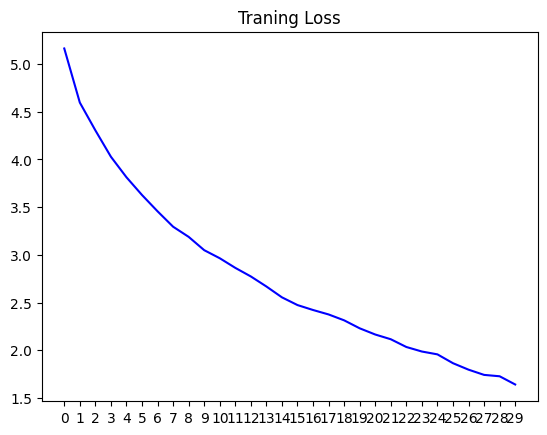

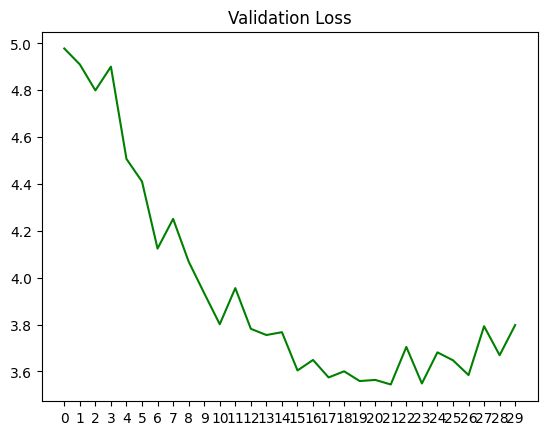

In [34]:
embedding_dim = 256
hidden_dim = 1024
dropout = 0.5
epoch_norm_grad = []

train_iterator, valid_iterator, test_iterator, source, target = get_datasets(batch_size=512)
model, optimizer, criterion = create_model(source, target, embedding_dim, hidden_dim, dropout)

model = train(model, optimizer, criterion, train_iterator, valid_iterator, epoch_norm_grad, epochs=30)

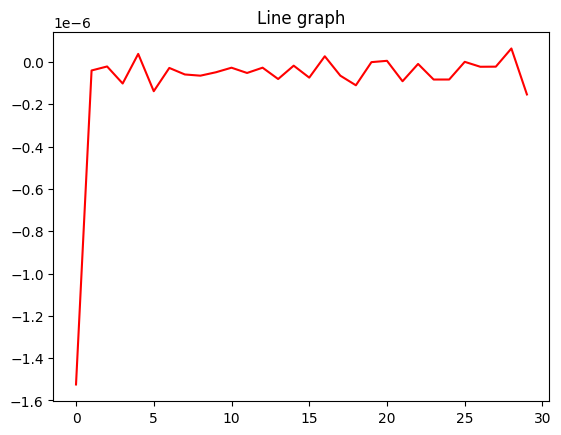

In [35]:
import matplotlib.pyplot as plt

plt.title("Line graph")
plt.plot(epoch_norm_grad, color="red")

plt.show()

In [36]:
test_data = get_test_datasets()

In [37]:
input, truth, predicted = predict(20, model, source.vocab, target.vocab, test_data)
print(f'Input sentence         = {" ".join(input)}')
print(f'Predicted sentence     = {" ".join(predicted)}')
print(f'Ground Truth sentence  = {" ".join(truth)}')

Input sentence         = . stehen gebäude einem vor die , leute
Predicted sentence     = people standing in front of a building . <eos>
Ground Truth sentence  = people standing outside of a building .


In [38]:
evaluate(test_data, model, source.vocab, target.vocab)

BLEU Score: 20.75


### <b> With Gradient Clipping </b>

In [5]:
class Encoder(nn.Module):
    def __init__(self, vocab_len, embedding_dim, hidden_dim, n_layers, dropout_prob):
        super().__init__()

        self.embedding = nn.Embedding(vocab_len, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers, dropout=dropout_prob)

        self.dropout = nn.Dropout(dropout_prob)

    def forward(self, input_batch):
        embed = self.dropout(self.embedding(input_batch))
        outputs, (hidden, cell) = self.lstm(embed)

        return hidden, cell

In [6]:
class OneStepDecoder(nn.Module):
    def __init__(self, input_output_dim, embedding_dim, hidden_dim, n_layers, dropout_prob):
        super().__init__()
        self.input_output_dim = input_output_dim

        self.embedding = nn.Embedding(input_output_dim, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers, dropout=dropout_prob)
        self.fc = nn.Linear(hidden_dim, input_output_dim)
        self.dropout = nn.Dropout(dropout_prob)

    def forward(self, target_token, hidden, cell):
        target_token = target_token.unsqueeze(0)
        embedding_layer = self.dropout(self.embedding(target_token))
        output, (hidden, cell) = self.lstm(embedding_layer, (hidden, cell))

        linear = self.fc(output.squeeze(0))

        return linear, hidden, cell


class Decoder(nn.Module):
    def __init__(self, one_step_decoder, device):
        super().__init__()
        self.one_step_decoder = one_step_decoder
        self.device = device

    def forward(self, target, hidden, cell, teacher_forcing_ratio=0.5):
        target_len, batch_size = target.shape[0], target.shape[1]
        target_vocab_size = self.one_step_decoder.input_output_dim

        predictions = torch.zeros(target_len, batch_size, target_vocab_size).to(self.device)
        input = target[0, :]

        # Loop through all the time steps, starts from 1
        for t in range(1, target_len):
            predict, hidden, cell = self.one_step_decoder(input, hidden, cell)

            predictions[t] = predict
            input = predict.argmax(1)

            # Teacher forcing
            do_teacher_forcing = random.random() < teacher_forcing_ratio
            input = target[t] if do_teacher_forcing else input

        return predictions

In [7]:
class EncoderDecoder(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()

        self.encoder = encoder
        self.decoder = decoder

    def forward(self, source, target, teacher_forcing_ratio=0.5):
        hidden, cell = self.encoder(source)
        outputs = self.decoder(target, hidden, cell, teacher_forcing_ratio)

        return outputs

In [8]:
def create_model(source, target, embedding_dim, hidden_dim, dropout):
    encoder = Encoder(len(source.vocab), embedding_dim, hidden_dim, n_layers=2, dropout_prob=dropout)
    one_step_decoder = OneStepDecoder(len(target.vocab), embedding_dim, hidden_dim, n_layers=2, dropout_prob=dropout)
    decoder = Decoder(one_step_decoder, device)

    model = EncoderDecoder(encoder, decoder)

    model = model.to(device)
    optimizer = optim.Adam(model.parameters())

    TARGET_PAD_IDX = target.vocab.stoi[target.pad_token]
    criterion = nn.CrossEntropyLoss(ignore_index=TARGET_PAD_IDX)

    return model, optimizer, criterion

In [49]:
def train(model, optimizer, criterion, train_iterator, valid_iterator, epoch_norm_grad_clip, epochs=25):
    clip = 2
    training_loss_epoch = []
    validation_loss_epoch = []

    for epoch in range(1, epochs + 1):
        pbar = tqdm(total=len(train_iterator), bar_format='{l_bar}{bar:10}{r_bar}{bar:-10b}', unit=' batches', ncols=200)

        training_loss = []
        batch_norm_grad = []

        model.train()

        for i, batch in enumerate(train_iterator):
            src = batch.src
            trg = batch.trg

            optimizer.zero_grad()

            output = model(src, trg)
            output_dim = output.shape[-1]

            # Discard the first token as this will always be 0
            output = output[1:].view(-1, output_dim)

            # Discard the sos token from target
            trg = trg[1:].view(-1)

            loss = criterion(output, trg)
            loss.backward()
            
            # -----------------------------Gradient Clipping for stability -----------------------------------------------------------------------------------------------------------------------
            torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
            
             # ------------------------store the gradients ------------------------------------So we can plot later
            for tag, value in model.named_parameters():
                if value.grad is not None:
                    batch_norm_grad.append(np.mean(value.grad.cpu().numpy()))
            
            optimizer.step()

            training_loss.append(loss.item())

            pbar.set_postfix(
                epoch=f" {epoch}, train loss= {round(sum(training_loss) / len(training_loss), 4)}", refresh=True)
            pbar.update()
        
        # Store the average gradient norm for each epoch
        epoch_norm_grad_clip.append(np.mean(batch_norm_grad))

        with torch.no_grad():
            model.eval()

            validation_loss = []

            # Loop through the validation batch
            for i, batch in enumerate(valid_iterator):
                src = batch.src
                trg = batch.trg

                output = model(src, trg, 0)
                output_dim = output.shape[-1]
                output = output[1:].view(-1, output_dim)
                trg = trg[1:].view(-1)

                loss = criterion(output, trg)

                validation_loss.append(loss.item())

        pbar.set_postfix(
            epoch=f" {epoch}, train loss= {round(sum(training_loss) / len(training_loss), 4)}, val loss= {round(sum(validation_loss) / len(validation_loss), 4)}",
            refresh=False)
        pbar.close()
        
        training_loss_epoch.append(round(sum(training_loss) / len(training_loss), 4))
        validation_loss_epoch.append(round(sum(validation_loss) / len(validation_loss), 4))

    plt.title("Traning Loss")
    plt.xticks(range(len(training_loss_epoch)))
    plt.plot(training_loss_epoch, color="blue")
    plt.show()
    
    plt.title("Validation Loss")
    plt.xticks(range(len(validation_loss_epoch)))
    plt.plot(validation_loss_epoch, color="green")
    plt.show()

    return model

In [10]:
def predict(id, model, source_vocab, target_vocab, test_data):
    src = vars(test_data.examples[id])['src']
    trg = vars(test_data.examples[id])['trg']

    # Convert each source token to integer values using the vocabulary
    tokens = ['<sos>'] + [token.lower() for token in src] + ['<eos>']
    src_indexes = [source_vocab.stoi[token] for token in tokens]
    src_tensor = torch.LongTensor(src_indexes).unsqueeze(1).to(device)

    model.eval()
    hidden, cell = model.encoder(src_tensor)

    # Take the integer value of <sos> from the target vocabulary.
    trg_index = [target_vocab.stoi['<sos>']]
    next_token = torch.LongTensor(trg_index).to(device)

    outputs = []
    trg_indexes = []

    with torch.no_grad():
        # Use the hidden and cell vector of the Encoder and in loop
        # run the forward pass of the OneStepDecoder until some specified
        # step (say 50) or when <eos> has been generated by the model.
        for _ in range(30):
            output, hidden, cell = model.decoder.one_step_decoder(next_token, hidden, cell)
            next_token = output.argmax(1)
            trg_indexes.append(next_token.item())

            # change token back to the respective word
            predicted = target_vocab.itos[output.argmax(1).item()]
            if predicted == '<eos>':
                break
            else:
                outputs.append(predicted)  

    predicted_words = [target_vocab.itos[i] for i in trg_indexes]
    return src, trg, predicted_words

In [11]:
def evaluate(dataset, model, source_vocab, target_vocab):
    targets = []
    predictions = []

    for i in range(len(dataset)):
        target = vars(test_data.examples[i])['trg']
        _, _, predicted_words = predict(i, model, source_vocab, target_vocab, dataset)
        predictions.append(predicted_words[1:-1])
        targets.append([target])

    print(f'BLEU Score: {round(bleu_score(predictions, targets) * 100, 2)}')

100%|██████████| 57/57 [00:31<00:00,  1.81 batches/s, epoch=30, train loss= 1.8608, val loss= 3.6744]                                                                                                   


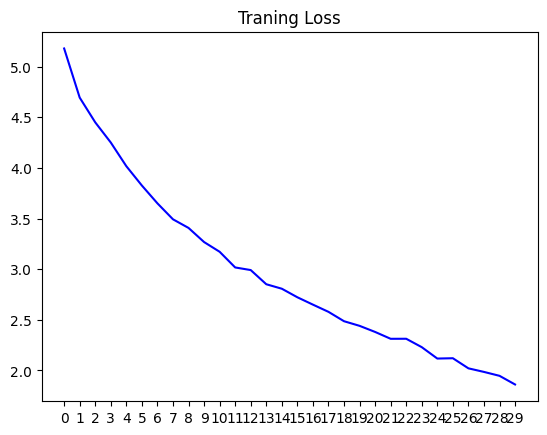

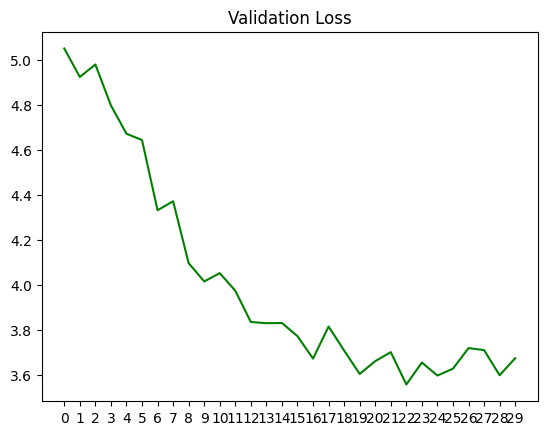

In [46]:
embedding_dim = 256
hidden_dim = 1024
dropout = 0.5
epoch_norm_grad_clip = []

train_iterator, valid_iterator, test_iterator, source, target = get_datasets(batch_size=512)
model, optimizer, criterion = create_model(source, target, embedding_dim, hidden_dim, dropout)

model = train(model, optimizer, criterion, train_iterator, valid_iterator, epoch_norm_grad_clip, epochs=30)

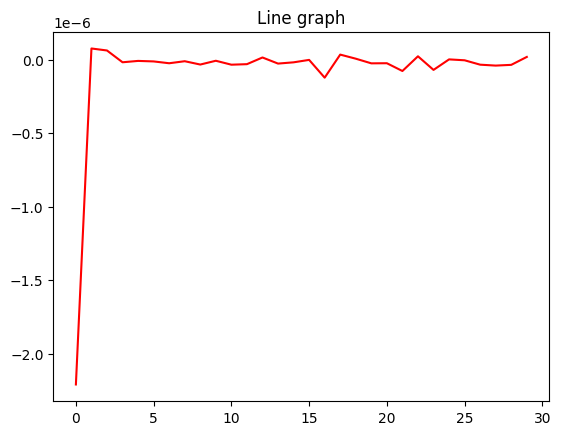

In [47]:
import matplotlib.pyplot as plt

plt.title("Line graph")
plt.plot(epoch_norm_grad_clip, color="red")

plt.show()

In [48]:
test_data = get_test_datasets()

In [49]:
input, truth, predicted = predict(20, model, source.vocab, target.vocab, test_data)
print(f'Input sentence         = {" ".join(input)}')
print(f'Predicted sentence     = {" ".join(predicted)}')
print(f'Ground Truth sentence  = {" ".join(truth)}')

Input sentence         = . stehen gebäude einem vor die , leute
Predicted sentence     = people standing outside of a building . <eos>
Ground Truth sentence  = people standing outside of a building .


In [50]:
evaluate(test_data, model, source.vocab, target.vocab)

BLEU Score: 19.49


## <b> Experiment 4 - Initial State Variations</b>

### <b> Initialize weights using Normal method</b>

In [12]:
class EncoderDecoder(nn.Module):
    def __init__(self, encoder, decoder, init_type):
        super().__init__()

        self.encoder = encoder
        self.decoder = decoder
        self.init_type = init_type
        self.apply(self._init_weights)
        
    def _init_weights(self, m):
        """
        initialize network's weights
        init_type: normal | xavier | kaiming | orthogonal
        """
        if hasattr(m, 'weight') and m.weight is not None:
            if hasattr(m.weight, 'data'):
                if self.init_type == 'normal':
                    nn.init.normal_(m.weight.data, 0.0)
                elif self.init_type == 'xavier':
                    nn.init.xavier_normal_(m.weight.data)
                elif self.init_type == 'xavier_uniform':
                    nn.init.xavier_uniform_(m.weight.data)
                elif self.init_type == 'kaiming':
                    nn.init.kaiming_normal_(m.weight.data, a=0, mode='fan_in')
                elif self.init_type == 'orthogonal':
                    nn.init.orthogonal_(m.weight.data)
                elif self.init_type == 'none':  # uses pytorch's default init method
                    m.reset_parameters()
                else:
                    print('initialization method [%s] is not implemented' % self.init_type)
        elif hasattr(m, 'bias') and m.bias is not None:
            if hasattr(m.bias, 'data'):
                if self.init_type == 'normal':
                    nn.init.normal_(m.bias.data, 0.0)
                elif self.init_type == 'xavier':
                    nn.init.xavier_normal_(m.bias.data)
                elif self.init_type == 'xavier_uniform':
                    nn.init.xavier_uniform_(m.bias.data)
                elif self.init_type == 'kaiming':
                    nn.init.kaiming_normal_(m.bias.data, a=0, mode='fan_in')
                elif self.init_type == 'orthogonal':
                    nn.init.orthogonal_(m.bias.data)
                elif self.init_type == 'none':  # uses pytorch's default init method
                    m.reset_parameters()
                else:
                    print('initialization method [%s] is not implemented' % self.init_type)


    def forward(self, source, target, teacher_forcing_ratio=0.5):
        hidden, cell = self.encoder(source)
        outputs = self.decoder(target, hidden, cell, teacher_forcing_ratio)

        return outputs

In [13]:
def create_model(source, target, embedding_dim, hidden_dim, dropout, init_type='normal'):
    encoder = Encoder(len(source.vocab), embedding_dim, hidden_dim, n_layers=2, dropout_prob=dropout)
    one_step_decoder = OneStepDecoder(len(target.vocab), embedding_dim, hidden_dim, n_layers=2, dropout_prob=dropout)
    decoder = Decoder(one_step_decoder, device)

    model = EncoderDecoder(encoder, decoder, init_type)

    model = model.to(device)
    optimizer = optim.Adam(model.parameters())

    TARGET_PAD_IDX = target.vocab.stoi[target.pad_token]
    criterion = nn.CrossEntropyLoss(ignore_index=TARGET_PAD_IDX)

    return model, optimizer, criterion

In [14]:
def train(model, optimizer, criterion, train_iterator, valid_iterator, epochs=25):
    training_loss_epoch = []
    validation_loss_epoch = []
    for epoch in range(1, epochs + 1):
        pbar = tqdm(total=len(train_iterator), bar_format='{l_bar}{bar:10}{r_bar}{bar:-10b}', unit=' batches', ncols=200)

        training_loss = []
        batch_norm_grad = []
        model.train()

        for i, batch in enumerate(train_iterator):
            src = batch.src
            trg = batch.trg

            optimizer.zero_grad()

            output = model(src, trg)
            output_dim = output.shape[-1]

            # Discard the first token as this will always be 0
            output = output[1:].view(-1, output_dim)

            # Discard the sos token from target
            trg = trg[1:].view(-1)

            loss = criterion(output, trg)
            loss.backward()
            
            optimizer.step()

            training_loss.append(loss.item())

            pbar.set_postfix(
                epoch=f" {epoch}, train loss= {round(sum(training_loss) / len(training_loss), 4)}", refresh=True)
            pbar.update()

        with torch.no_grad():
            model.eval()

            validation_loss = []

            # Loop through the validation batch
            for i, batch in enumerate(valid_iterator):
                src = batch.src
                trg = batch.trg

                output = model(src, trg, 0)
                output_dim = output.shape[-1]
                output = output[1:].view(-1, output_dim)
                trg = trg[1:].view(-1)

                loss = criterion(output, trg)

                validation_loss.append(loss.item())

        pbar.set_postfix(
            epoch=f" {epoch}, train loss= {round(sum(training_loss) / len(training_loss), 4)}, val loss= {round(sum(validation_loss) / len(validation_loss), 4)}",
            refresh=False)
        pbar.close()
        
        training_loss_epoch.append(round(sum(training_loss) / len(training_loss), 4))
        validation_loss_epoch.append(round(sum(validation_loss) / len(validation_loss), 4))

    plt.title("Traning Loss")
    plt.xticks(range(len(training_loss_epoch)))
    plt.plot(training_loss_epoch, color="blue")
    plt.show()
    
    plt.title("Validation Loss")
    plt.xticks(range(len(validation_loss_epoch)))
    plt.plot(validation_loss_epoch, color="green")
    plt.show()

    return model

In [15]:
def evaluate(dataset, model, source_vocab, target_vocab):
    targets = []
    predictions = []

    for i in range(len(dataset)):
        target = vars(test_data.examples[i])['trg']
        _, _, predicted_words = predict(i, model, source_vocab, target_vocab, dataset)
        predictions.append(predicted_words[1:-1])
        targets.append([target])

    print(f'BLEU Score: {round(bleu_score(predictions, targets) * 100, 2)}')

100%|██████████| 57/57 [00:30<00:00,  1.90 batches/s, epoch=30, train loss= 1.239, val loss= 5.0422]                                                                                                    


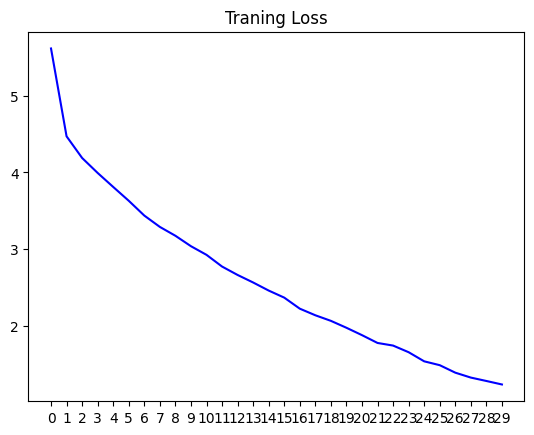

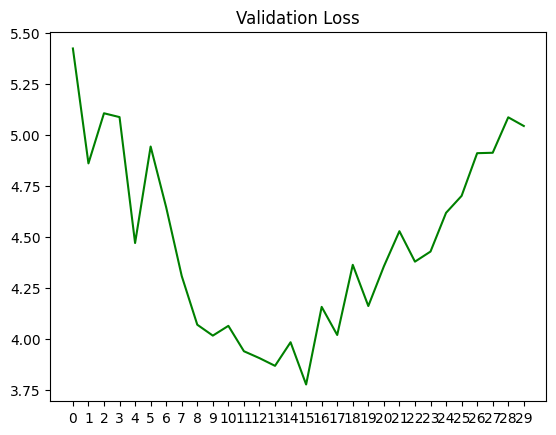

In [16]:
embedding_dim = 256
hidden_dim = 1024
dropout = 0.5

train_iterator, valid_iterator, test_iterator, source, target = get_datasets(batch_size=512)
model, optimizer, criterion = create_model(source, target, embedding_dim, hidden_dim, dropout, init_type='normal')

model = train(model, optimizer, criterion, train_iterator, valid_iterator, epochs=30)

In [17]:
test_data = get_test_datasets()

In [18]:
input, truth, predicted = predict(20, model, source.vocab, target.vocab, test_data)
print(f'Input sentence         = {" ".join(input)}')
print(f'Predicted sentence     = {" ".join(predicted)}')
print(f'Ground Truth sentence  = {" ".join(truth)}')

Input sentence         = . stehen gebäude einem vor die , leute
Predicted sentence     = people located outside of a building . <eos>
Ground Truth sentence  = people standing outside of a building .


In [19]:
evaluate(test_data, model, source.vocab, target.vocab)

BLEU Score: 16.88


### <b> Initialize weights using xavier method</b>

100%|██████████| 57/57 [00:29<00:00,  1.91 batches/s, epoch=30, train loss= 2.0366, val loss= 3.9359]                                                                                                   


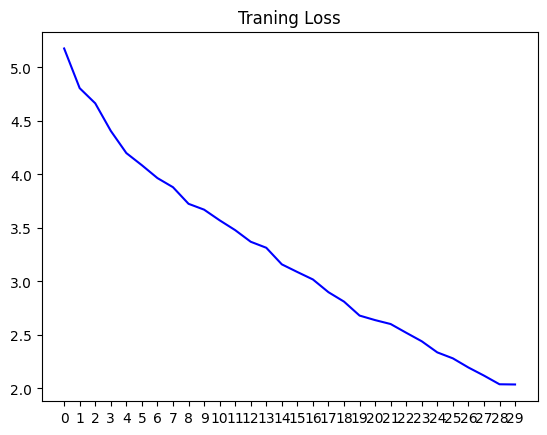

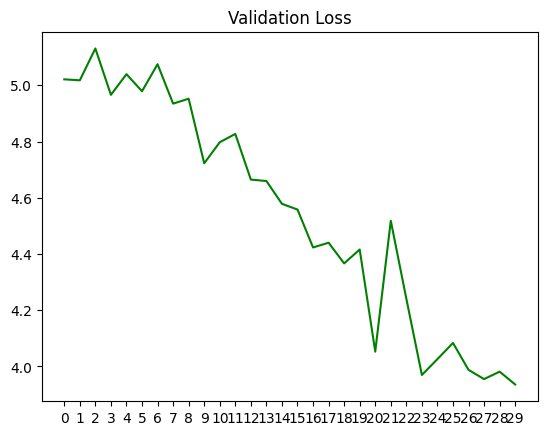

In [20]:
embedding_dim = 256
hidden_dim = 1024
dropout = 0.5

train_iterator, valid_iterator, test_iterator, source, target = get_datasets(batch_size=512)
model, optimizer, criterion = create_model(source, target, embedding_dim, hidden_dim, dropout, init_type='xavier')

model = train(model, optimizer, criterion, train_iterator, valid_iterator, epochs=30)

In [21]:
test_data = get_test_datasets()

In [22]:
input, truth, predicted = predict(20, model, source.vocab, target.vocab, test_data)
print(f'Input sentence         = {" ".join(input)}')
print(f'Predicted sentence     = {" ".join(predicted)}')
print(f'Ground Truth sentence  = {" ".join(truth)}')

Input sentence         = . stehen gebäude einem vor die , leute
Predicted sentence     = people standing in front of a building . <eos>
Ground Truth sentence  = people standing outside of a building .


In [23]:
evaluate(test_data, model, source.vocab, target.vocab)

BLEU Score: 15.76


### <b> Initialize weights using Xavier Uniform method</b>

100%|██████████| 57/57 [00:29<00:00,  1.91 batches/s, epoch=30, train loss= 1.717, val loss= 3.8953]                                                                                                    


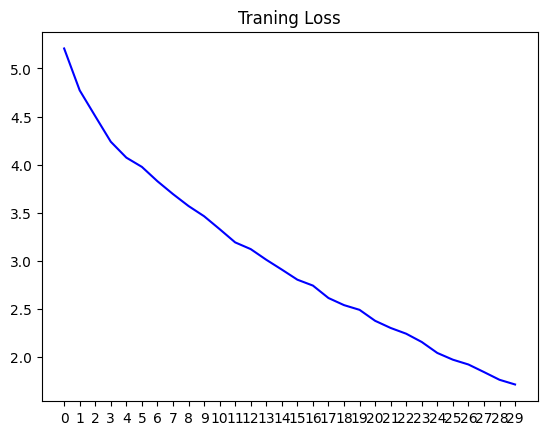

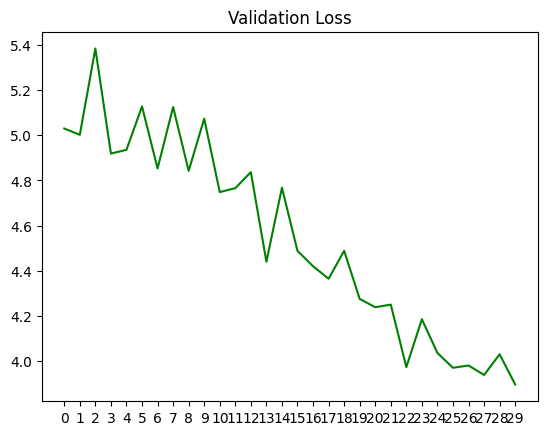

In [24]:
embedding_dim = 256
hidden_dim = 1024
dropout = 0.5

train_iterator, valid_iterator, test_iterator, source, target = get_datasets(batch_size=512)
model, optimizer, criterion = create_model(source, target, embedding_dim, hidden_dim, dropout, init_type='xavier_uniform')

model = train(model, optimizer, criterion, train_iterator, valid_iterator, epochs=30)

In [25]:
test_data = get_test_datasets()

In [26]:
input, truth, predicted = predict(20, model, source.vocab, target.vocab, test_data)
print(f'Input sentence         = {" ".join(input)}')
print(f'Predicted sentence     = {" ".join(predicted)}')
print(f'Ground Truth sentence  = {" ".join(truth)}')

Input sentence         = . stehen gebäude einem vor die , leute
Predicted sentence     = people standing outside a building . <eos>
Ground Truth sentence  = people standing outside of a building .


In [27]:
evaluate(test_data, model, source.vocab, target.vocab)

BLEU Score: 17.5


### <b> Initialize weights using kaiming method</b>

100%|██████████| 57/57 [00:29<00:00,  1.91 batches/s, epoch=30, train loss= 1.095, val loss= 4.0516]                                                                                                    


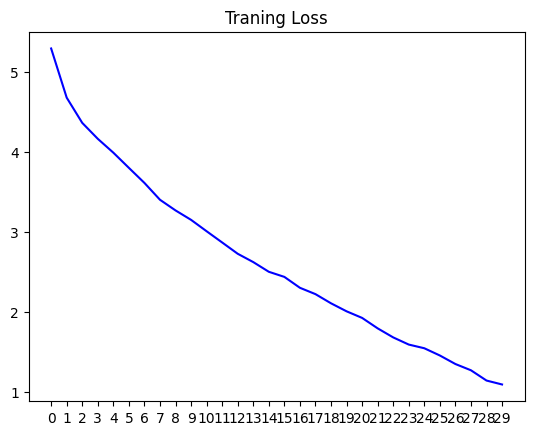

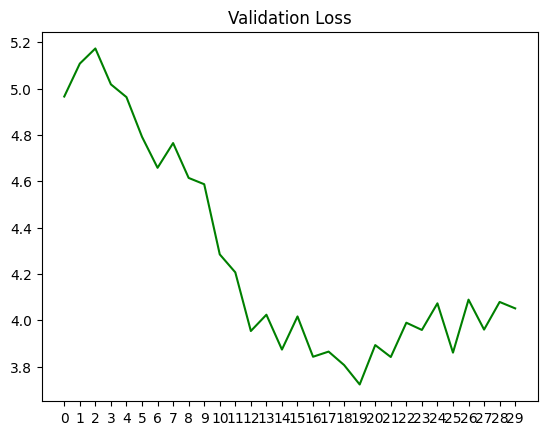

In [28]:
embedding_dim = 256
hidden_dim = 1024
dropout = 0.5

train_iterator, valid_iterator, test_iterator, source, target = get_datasets(batch_size=512)
model, optimizer, criterion = create_model(source, target, embedding_dim, hidden_dim, dropout, init_type='kaiming')

model = train(model, optimizer, criterion, train_iterator, valid_iterator, epochs=30)

In [29]:
test_data = get_test_datasets()

In [30]:
input, truth, predicted = predict(20, model, source.vocab, target.vocab, test_data)
print(f'Input sentence         = {" ".join(input)}')
print(f'Predicted sentence     = {" ".join(predicted)}')
print(f'Ground Truth sentence  = {" ".join(truth)}')

Input sentence         = . stehen gebäude einem vor die , leute
Predicted sentence     = people standing in front of a building . <eos>
Ground Truth sentence  = people standing outside of a building .


In [31]:
evaluate(test_data, model, source.vocab, target.vocab)

BLEU Score: 18.15


### <b> Initialize weights using orthogonal method</b>

100%|██████████| 57/57 [00:29<00:00,  1.92 batches/s, epoch=30, train loss= 2.2318, val loss= 4.0326]                                                                                                   


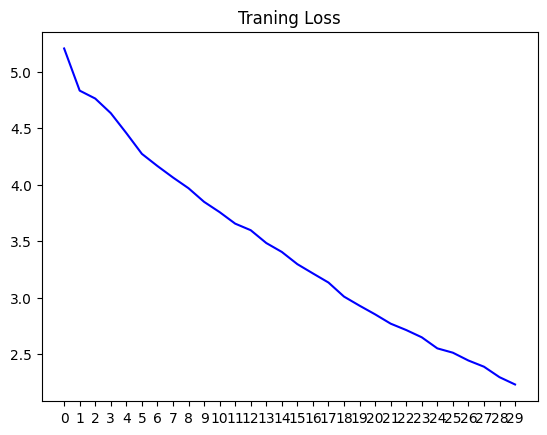

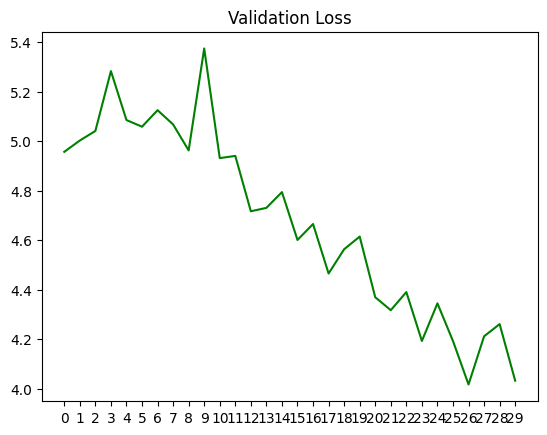

In [32]:
embedding_dim = 256
hidden_dim = 1024
dropout = 0.5

train_iterator, valid_iterator, test_iterator, source, target = get_datasets(batch_size=512)
model, optimizer, criterion = create_model(source, target, embedding_dim, hidden_dim, dropout, init_type='orthogonal')

model = train(model, optimizer, criterion, train_iterator, valid_iterator, epochs=30)

In [33]:
test_data = get_test_datasets()

In [34]:
input, truth, predicted = predict(20, model, source.vocab, target.vocab, test_data)
print(f'Input sentence         = {" ".join(input)}')
print(f'Predicted sentence     = {" ".join(predicted)}')
print(f'Ground Truth sentence  = {" ".join(truth)}')

Input sentence         = . stehen gebäude einem vor die , leute
Predicted sentence     = people standing in front of a building . <eos>
Ground Truth sentence  = people standing outside of a building .


In [35]:
evaluate(test_data, model, source.vocab, target.vocab)

BLEU Score: 15.46


## <b> Experiment 5 - Exploring Hyperparameter Variations</b>

### <b> Number of LSTM Layers: 4</b>

In [16]:
def create_model(source, target, embedding_dim, hidden_dim, dropout, n_layers, init_type='none'):
    encoder = Encoder(len(source.vocab), embedding_dim, hidden_dim, n_layers=n_layers, dropout_prob=dropout)
    one_step_decoder = OneStepDecoder(len(target.vocab), embedding_dim, hidden_dim, n_layers=n_layers, dropout_prob=dropout)
    decoder = Decoder(one_step_decoder, device)

    model = EncoderDecoder(encoder, decoder, init_type)

    model = model.to(device)
    optimizer = optim.Adam(model.parameters())

    TARGET_PAD_IDX = target.vocab.stoi[target.pad_token]
    criterion = nn.CrossEntropyLoss(ignore_index=TARGET_PAD_IDX)

    return model, optimizer, criterion

100%|██████████| 57/57 [00:52<00:00,  1.08 batches/s, epoch=30, train loss= 2.5481, val loss= 3.9327]                                                                                                   


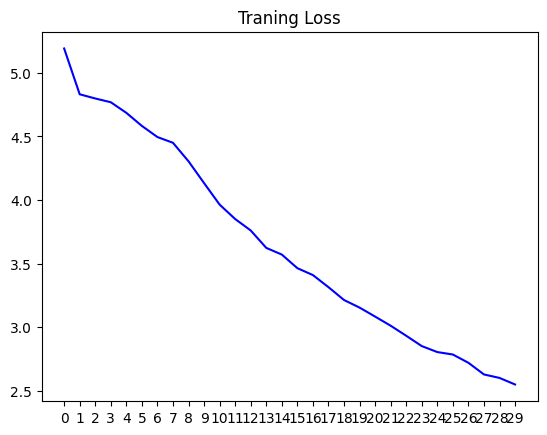

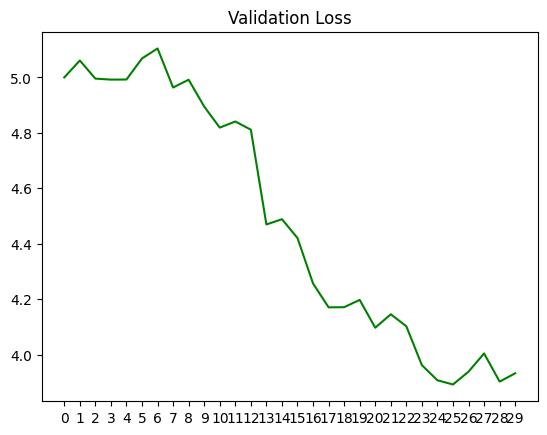

In [37]:
embedding_dim = 256
hidden_dim = 1024
dropout = 0.5
n_layers = 4

train_iterator, valid_iterator, test_iterator, source, target = get_datasets(batch_size=512)
model, optimizer, criterion = create_model(source, target, embedding_dim, hidden_dim, dropout, n_layers, init_type='none')

model = train(model, optimizer, criterion, train_iterator, valid_iterator, epochs=30)

In [38]:
test_data = get_test_datasets()

In [39]:
input, truth, predicted = predict(20, model, source.vocab, target.vocab, test_data)
print(f'Input sentence         = {" ".join(input)}')
print(f'Predicted sentence     = {" ".join(predicted)}')
print(f'Ground Truth sentence  = {" ".join(truth)}')

Input sentence         = . stehen gebäude einem vor die , leute
Predicted sentence     = people standing outside outside of a building . <eos>
Ground Truth sentence  = people standing outside of a building .


In [40]:
evaluate(test_data, model, source.vocab, target.vocab)

BLEU Score: 13.74


### <b> Number of LSTM Layers: 8</b>

In [19]:
def create_model(source, target, embedding_dim, hidden_dim, dropout, n_layers, init_type='none'):
    encoder = Encoder(len(source.vocab), embedding_dim, hidden_dim, n_layers=n_layers, dropout_prob=dropout)
    one_step_decoder = OneStepDecoder(len(target.vocab), embedding_dim, hidden_dim, n_layers=n_layers, dropout_prob=dropout)
    decoder = Decoder(one_step_decoder, device)

    model = EncoderDecoder(encoder, decoder, init_type)

    model = model.to(device)
    optimizer = optim.Adam(model.parameters())

    TARGET_PAD_IDX = target.vocab.stoi[target.pad_token]
    criterion = nn.CrossEntropyLoss(ignore_index=TARGET_PAD_IDX)

    return model, optimizer, criterion

In [20]:
embedding_dim = 256
hidden_dim = 1024
dropout = 0.5
n_layers = 8
epoch_norm_grad_clip = []

train_iterator, valid_iterator, test_iterator, source, target = get_datasets(batch_size=512)
model, optimizer, criterion = create_model(source, target, embedding_dim, hidden_dim, dropout, n_layers, init_type='none')

model = train(model, optimizer, criterion, train_iterator, valid_iterator, epoch_norm_grad_clip, epochs=30)

  9%|▉         | 5/57 [00:05<01:01,  1.18s/ batches, epoch=1, train loss= 7.155]                                                                                                                        

RuntimeError: CUDA out of memory. Tried to allocate 406.00 MiB (GPU 0; 7.92 GiB total capacity; 6.20 GiB already allocated; 56.69 MiB free; 7.12 GiB reserved in total by PyTorch)

In [ ]:
test_data = get_test_datasets()

In [ ]:
input, truth, predicted = predict(20, model, source.vocab, target.vocab, test_data)
print(f'Input sentence         = {" ".join(input)}')
print(f'Predicted sentence     = {" ".join(predicted)}')
print(f'Ground Truth sentence  = {" ".join(truth)}')

In [ ]:
evaluate(test_data, model, source.vocab, target.vocab)

### <b> Embedding Dim: 128</b>

100%|██████████| 57/57 [00:29<00:00,  1.96 batches/s, epoch=30, train loss= 1.8124, val loss= 3.7061]                                                                                                   


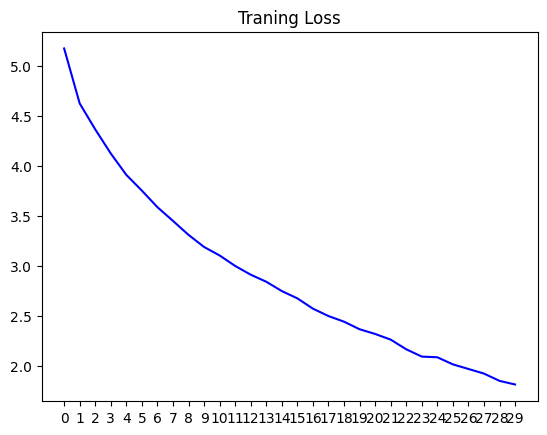

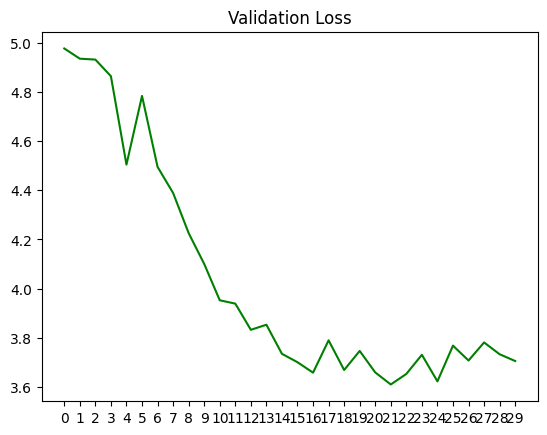

In [41]:
embedding_dim = 128
hidden_dim = 1024
dropout = 0.5
n_layers = 2

train_iterator, valid_iterator, test_iterator, source, target = get_datasets(batch_size=512)
model, optimizer, criterion = create_model(source, target, embedding_dim, hidden_dim, dropout, n_layers, init_type='none')

model = train(model, optimizer, criterion, train_iterator, valid_iterator, epochs=30)

In [42]:
test_data = get_test_datasets()

In [43]:
input, truth, predicted = predict(20, model, source.vocab, target.vocab, test_data)
print(f'Input sentence         = {" ".join(input)}')
print(f'Predicted sentence     = {" ".join(predicted)}')
print(f'Ground Truth sentence  = {" ".join(truth)}')

Input sentence         = . stehen gebäude einem vor die , leute
Predicted sentence     = people standing outside a building . <eos>
Ground Truth sentence  = people standing outside of a building .


In [44]:
evaluate(test_data, model, source.vocab, target.vocab)

BLEU Score: 18.54


### <b> Embedding Dim: 512</b>

100%|██████████| 57/57 [00:31<00:00,  1.83 batches/s, epoch=30, train loss= 1.417, val loss= 3.6775]                                                                                                    


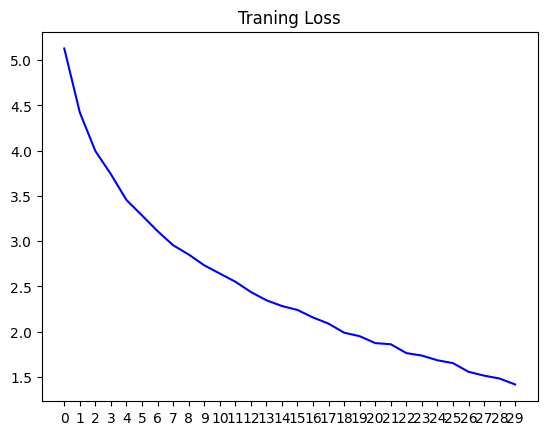

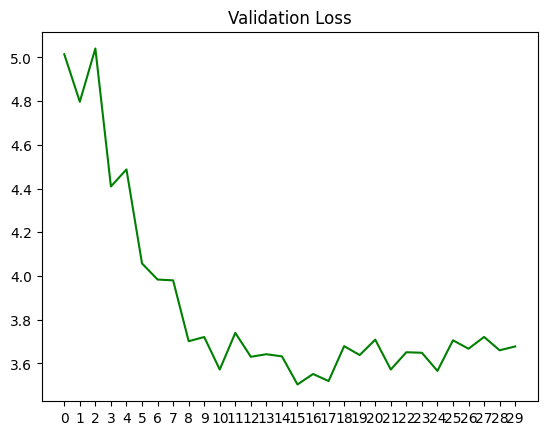

In [45]:
embedding_dim = 512
hidden_dim = 1024
dropout = 0.5
n_layers = 2

train_iterator, valid_iterator, test_iterator, source, target = get_datasets(batch_size=512)
model, optimizer, criterion = create_model(source, target, embedding_dim, hidden_dim, dropout, n_layers, init_type='none')

model = train(model, optimizer, criterion, train_iterator, valid_iterator, epochs=30)

In [46]:
test_data = get_test_datasets()

In [47]:
input, truth, predicted = predict(20, model, source.vocab, target.vocab, test_data)
print(f'Input sentence         = {" ".join(input)}')
print(f'Predicted sentence     = {" ".join(predicted)}')
print(f'Ground Truth sentence  = {" ".join(truth)}')

Input sentence         = . stehen gebäude einem vor die , leute
Predicted sentence     = people standing outside of building building . <eos>
Ground Truth sentence  = people standing outside of a building .


In [48]:
evaluate(test_data, model, source.vocab, target.vocab)

BLEU Score: 21.2


### <b> Hidden Dim: 512</b>

100%|██████████| 57/57 [00:15<00:00,  3.59 batches/s, epoch=30, train loss= 2.4046, val loss= 3.5754]                                                                                                   


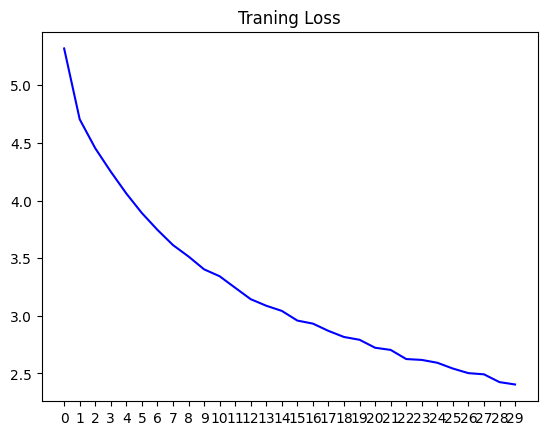

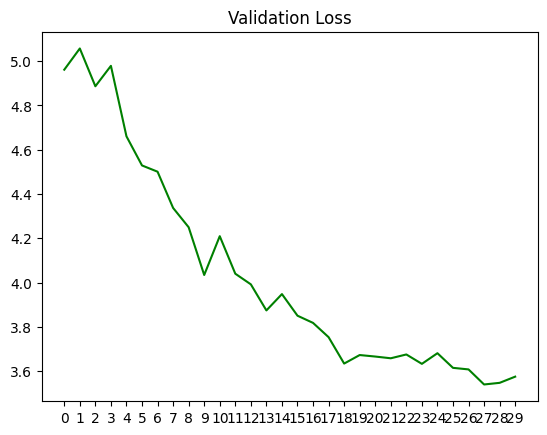

In [49]:
embedding_dim = 256
hidden_dim = 512
dropout = 0.5
n_layers = 2

train_iterator, valid_iterator, test_iterator, source, target = get_datasets(batch_size=512)
model, optimizer, criterion = create_model(source, target, embedding_dim, hidden_dim, dropout, n_layers, init_type='none')

model = train(model, optimizer, criterion, train_iterator, valid_iterator, epochs=30)

In [50]:
test_data = get_test_datasets()

In [51]:
input, truth, predicted = predict(20, model, source.vocab, target.vocab, test_data)
print(f'Input sentence         = {" ".join(input)}')
print(f'Predicted sentence     = {" ".join(predicted)}')
print(f'Ground Truth sentence  = {" ".join(truth)}')

Input sentence         = . stehen gebäude einem vor die , leute
Predicted sentence     = people standing outside of a building building . <eos>
Ground Truth sentence  = people standing outside of a building .


In [52]:
evaluate(test_data, model, source.vocab, target.vocab)

BLEU Score: 17.56


### <b> Hidden Dim: 2048</b>

In [58]:
embedding_dim = 256
hidden_dim = 2048
dropout = 0.5
n_layers = 2
epoch_norm_grad_clip = []

train_iterator, valid_iterator, test_iterator, source, target = get_datasets(batch_size=512)
model, optimizer, criterion = create_model(source, target, embedding_dim, hidden_dim, dropout, n_layers, init_type='none')

model = train(model, optimizer, criterion, train_iterator, valid_iterator, epoch_norm_grad_clip, epochs=30)

 60%|█████▉    | 34/57 [00:56<00:36,  1.61s/ batches, epoch=1, train loss= 5.2713]                                                                                                                      

RuntimeError: CUDA out of memory. Tried to allocate 364.00 MiB (GPU 0; 7.92 GiB total capacity; 6.15 GiB already allocated; 259.50 MiB free; 6.78 GiB reserved in total by PyTorch)

In [ ]:
test_data = get_test_datasets()

In [ ]:
input, truth, predicted = predict(20, model, source.vocab, target.vocab, test_data)
print(f'Input sentence         = {" ".join(input)}')
print(f'Predicted sentence     = {" ".join(predicted)}')
print(f'Ground Truth sentence  = {" ".join(truth)}')

In [ ]:
evaluate(test_data, model, source.vocab, target.vocab)

### <b> Dropout = 0.1</b>

100%|██████████| 57/57 [00:30<00:00,  1.90 batches/s, epoch=30, train loss= 0.5215, val loss= 4.8437]                                                                                                   


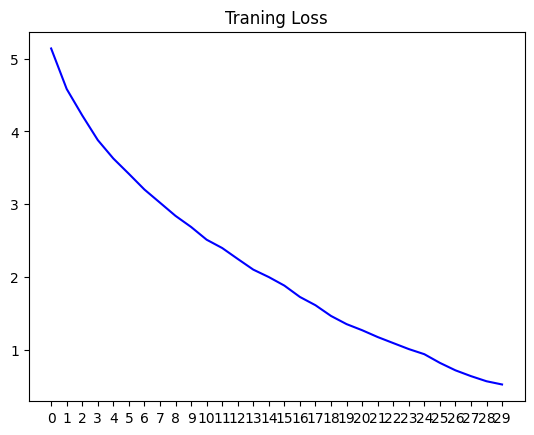

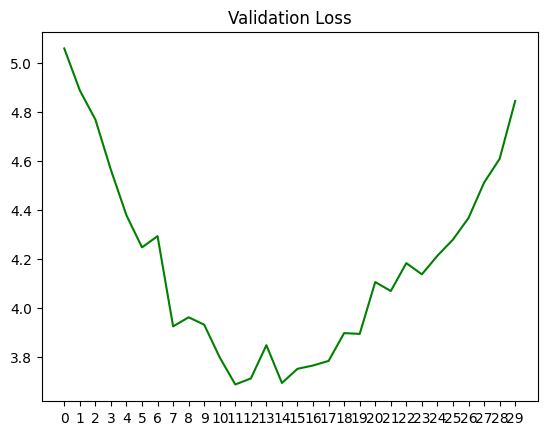

In [17]:
embedding_dim = 256
hidden_dim = 1024
dropout = 0.1
n_layers = 2

train_iterator, valid_iterator, test_iterator, source, target = get_datasets(batch_size=512)
model, optimizer, criterion = create_model(source, target, embedding_dim, hidden_dim, dropout, n_layers, init_type='none')

model = train(model, optimizer, criterion, train_iterator, valid_iterator, epochs=30)

In [18]:
test_data = get_test_datasets()

In [19]:
input, truth, predicted = predict(20, model, source.vocab, target.vocab, test_data)
print(f'Input sentence         = {" ".join(input)}')
print(f'Predicted sentence     = {" ".join(predicted)}')
print(f'Ground Truth sentence  = {" ".join(truth)}')

Input sentence         = . stehen gebäude einem vor die , leute
Predicted sentence     = people standing in front of a building . <eos>
Ground Truth sentence  = people standing outside of a building .


In [20]:
evaluate(test_data, model, source.vocab, target.vocab)

BLEU Score: 19.52


### <b> Dropout = 0.3</b>

100%|██████████| 57/57 [00:29<00:00,  1.91 batches/s, epoch=30, train loss= 0.9706, val loss= 4.0965]                                                                                                   


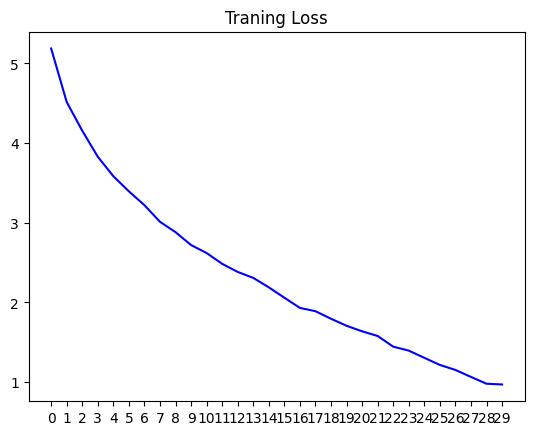

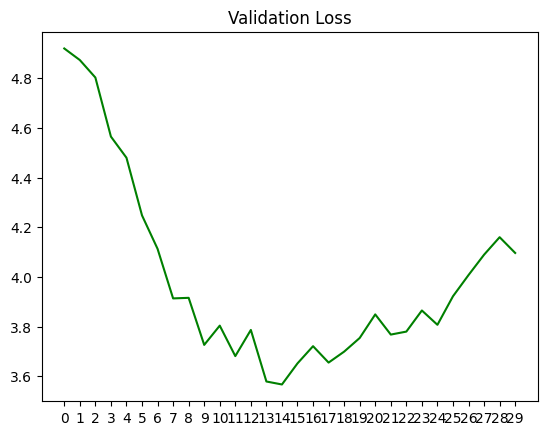

In [21]:
embedding_dim = 256
hidden_dim = 1024
dropout = 0.3
n_layers = 2

train_iterator, valid_iterator, test_iterator, source, target = get_datasets(batch_size=512)
model, optimizer, criterion = create_model(source, target, embedding_dim, hidden_dim, dropout, n_layers, init_type='none')

model = train(model, optimizer, criterion, train_iterator, valid_iterator, epochs=30)

In [22]:
test_data = get_test_datasets()

In [23]:
input, truth, predicted = predict(20, model, source.vocab, target.vocab, test_data)
print(f'Input sentence         = {" ".join(input)}')
print(f'Predicted sentence     = {" ".join(predicted)}')
print(f'Ground Truth sentence  = {" ".join(truth)}')

Input sentence         = . stehen gebäude einem vor die , leute
Predicted sentence     = people standing in front of a building . <eos>
Ground Truth sentence  = people standing outside of a building .


In [24]:
evaluate(test_data, model, source.vocab, target.vocab)

BLEU Score: 20.97


In [25]:
model.summary()

AttributeError: 'EncoderDecoder' object has no attribute 'summary'

In [35]:
model

EncoderDecoder(
  (encoder): Encoder(
    (embedding): Embedding(5374, 256)
    (lstm): LSTM(256, 1024, num_layers=2, dropout=0.5)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (one_step_decoder): OneStepDecoder(
      (embedding): Embedding(4556, 256)
      (lstm): LSTM(256, 1024, num_layers=2, dropout=0.5)
      (fc): Linear(in_features=1024, out_features=4556, bias=True)
      (dropout): Dropout(p=0.5, inplace=False)
    )
  )
)